In [1]:
# all imports 
%pylab inline

import os
import sys
import socket

sys.path.append("/root")
sys.path.append("/home/peter")
sys.path.append("/home/peter/Desktop")
sys.path.append("/home/peter/Desktop/projects")
sys.path.append("/home/peter/Desktop/work")
sys.path.append("/home/peter/code/projects")
sys.path.append("/home/peter/code/work")
sys.path.append("/home/peter/code/common")

from ipywidgets import interact, interactive, fixed, IntSlider, FloatSlider
from IPython.display import clear_output, display, HTML

import cv2
import os
import pickle as pkl
from sklearn import linear_model
from sklearn.decomposition import PCA
import random as rnd
import numpy as np
import matplotlib.pyplot as plt

import theano.tensor as T
import theano as th

from aidevutil import *

import cymysql as sql
import pandas as pd
from tqdm import tqdm_notebook as tqdm
import datetime
import time
from sklearn.preprocessing import scale, robust_scale, normalize
from trading_env import TradingEnv
from skrules import SkopeRules
from sklearn.metrics import precision_recall_curve

Populating the interactive namespace from numpy and matplotlib


Using cuDNN version 7600 on context None
Mapped name None to device cuda: GeForce GTX 1080 (0000:01:00.0)
Using Theano backend.


vizdoom could not be imported


In [2]:
input_source = np.load(open('data_btc_1h.npy','rb'))
to_predict = np.load(open('data_btc_1h_targets.npy','rb'))

to_predict = to_predict[3,:].reshape(-1)

In [3]:
input_source.shape

(176, 16900)

In [4]:
input_source = input_source.T

In [5]:
is_orig = np.copy(input_source)
cp = int(0.8*len(input_source))
test_input_source = input_source[cp:, :]
test_to_predict = to_predict[cp:]
input_source = input_source[0:cp, :]
to_predict = to_predict[0:cp]

In [6]:
test_input_source = test_input_source.T
input_source = input_source.T

In [7]:
input_source.shape, test_input_source.shape

((176, 13520), (176, 3380))

In [8]:
to_predict[0:50]

array([2541.67, 2561.88, 2561.11, 2565.42, 2564.37, 2564.66, 2566.99,
       2572.95, 2559.39, 2555.95, 2549.65, 2548.63, 2553.98, 2554.6 ,
       2553.34, 2552.78, 2552.33, 2556.92, 2559.32, 2555.67, 2553.79,
       2539.82, 2542.72, 2538.99, 2535.  , 2522.98, 2508.99, 2497.15,
       2517.  , 2514.86, 2511.02, 2512.94, 2516.73, 2516.29, 2515.91,
       2515.  , 2517.83, 2514.75, 2494.88, 2470.  , 2430.73, 2403.21,
       2383.14, 2412.81, 2420.19, 2399.22, 2404.61, 2390.  , 2341.31,
       2332.92])

In [9]:
winlen = 1

In [10]:
sliding_window_jump = 1
predict_time_ahead = 1

In [11]:
def get_partitioned_counts(cl, rr, rt):
    " data, steps_forward, partition_num"
    cl = cl[rr:] - cl[0:-rr]
    cl = hstack([[0]*rr, cl])
    pdown = len(cl[cl < -rt])
    pup = len(cl[cl > rt])
    pmid = len(cl[(cl <= rt) & (cl >= -rt)])
    return pup, pmid, pdown

In [12]:
def partition_data_num(cl, predict_ahead):
    a=[]
    b=[]
    c=[]
    ts = np.linspace(0.001, 10.0, 100000, )
    for x in tqdm(ts):
        au, am, ad = get_partitioned_counts(cl, predict_ahead, x)
        a.append(au)
        b.append(am)
        c.append(ad)
    a, b, c = array(a), array(b), array(c)
    return ts[np.argmin(np.abs(a-b) + np.abs(a-c) + np.abs(b-c))]

In [13]:
# create training set
sep = 10.8#partition_data_num(to_predict, predict_time_ahead)
sep

10.8

In [14]:
def prepare_data(input_source, to_predict):
    x = []
    y = []

    ups = []
    downs = []
    mids = []

    for i in range(0, input_source.shape[1]-(winlen+100), sliding_window_jump):
        # form the input
        xs = input_source[:, i:i+winlen]
        #xs = scale(xs, axis=1)
        xs = xs.ravel()

        # for the output
        now = to_predict[i+winlen-1].ravel() # close
        future = to_predict[i+winlen+(predict_time_ahead-1)].ravel() # next close

        ys = future-now
        magn = abs(ys)

        if magn < sep:
            mids.append( (xs, (np.array([1]))) )
        else:
            if ys < 0:
                downs.append( (xs, (np.array([2]))) )
            else:
                ups.append( (xs, (np.array([0]))) )

        #if (i%1000)==0:
        #    clear_output(wait=True)
        #    print('({}/{})'.format(i, input_source.shape[1]-winlen))

    #print('Ups: {0} Mids: {1} Downs: {2}'.format(len(ups), len(mids), len(downs)))
    #print('Separator: %3.5f' % sep)
    #print()

    samplesize = min(len(ups), len(downs), len(mids))
    s1 = rnd.sample(ups, samplesize)
    s2 = rnd.sample(downs, samplesize)
    s3 = rnd.sample(mids, samplesize)
    a = s1 + s2 + s3
    rnd.shuffle(a)
    x = [x[0] for x in a]
    y = [x[1] for x in a]

    x = np.vstack(x)
    y = np.vstack(y)
    
    x.shape = (x.shape[0], -1)
    cutpoint = int(0.8 * x.shape[0])
    x_train = x[0:cutpoint]
    x_test = x[cutpoint:]
    y_train = y[0:cutpoint]
    y_test = y[cutpoint:]
    
    return x_train, x_test, y_train, y_test

In [15]:
x_train, x_test, y_train, y_test = prepare_data(input_source, to_predict)

In [16]:
feature_names = ['feature_'+str(i) for i in range(input_source.shape[0])]
skr = SkopeRules(max_depth_duplication=2,
                 n_estimators=30,
                 precision_min=0.3,
                 recall_min=0.1,
                 feature_names=feature_names)

In [17]:
skr.fit(x_train, y_train)
rules = skr.rules_[0:10]
print("Rules for dataset:")
for rule in rules:
    print(rule)
print()

Rules for dataset:
('feature_26 <= 0.526180773973465 and feature_70 > -0.37955600023269653 and feature_81 > -0.5292375683784485', (0.7335513659099654, 0.6892624728850325, 1))
('feature_21 > -0.6473398208618164 and feature_26 <= 0.6348899900913239 and feature_30 > -0.34182173013687134', (0.7383697813121273, 0.6696718355571583, 1))
('feature_21 <= 0.5816715955734253 and feature_30 > -0.33584725856781006 and feature_99 > -0.36799387633800507', (0.7440514469453376, 0.6284627919608908, 1))
('feature_26 <= 0.6940873265266418 and feature_29 > -0.1932835951447487 and feature_3 > -0.28305938839912415', (0.7407486631016043, 0.6278100072516316, 1))
('feature_13 > -3.512663722038269 and feature_30 <= -0.2350311204791069 and feature_62 <= 2.1339255571365356', (0.5272331154684096, 0.1746031746031746, 1))
('feature_25 > -1.7771132588386536 and feature_30 <= -0.2392001375555992 and feature_82 > -2.4791996479034424', (0.5561561561561561, 0.16754116157047222, 1))
('feature_40 > -3.126358389854431 and fe

In [20]:
y_score = skr.score_top_rules(x_test) # Get a risk score for each test example
#precision, recall, _ = precision_recall_curve(y_test, y_score)
#plt.plot(recall, precision)
#plt.xlabel('Recall')
#plt.ylabel('Precision')
#plt.title('Precision Recall curve')
#plt.show()
y_score

array([7., 8., 8., ..., 8., 4., 7.])

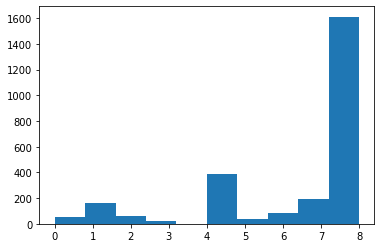

In [22]:
hist(y_score);

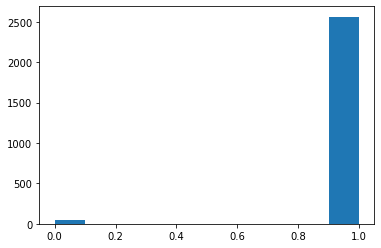

In [24]:
t = skr.predict(x_test)
hist(t);

In [ ]:
from sklearn.ensemble import AdaBoostClassifier

In [ ]:
# Classifiers
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, ExtraTreesClassifier, GradientBoostingClassifier 
from sklearn.naive_bayes import GaussianNB
#from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier

In [ ]:
import sklearn as sk
import time

In [ ]:
clf = LogisticRegression()

In [ ]:
%%time

clf.fit(x_train, y_train)

In [ ]:
clf.score(x_train, y_train)

In [ ]:
clf.score(x_test, y_test)

In [ ]:
input_source.shape, to_predict.shape, test_input_source.shape, test_to_predict.shape

In [ ]:
traded_amt = 100
commission = 0
slippage = 0
initial_balance = 100000000

In [ ]:
def plot_backtest(datapair, clf): 
    input_source, to_predict = datapair
    bars_per_episode = len(to_predict) - 1000
    env = TradingEnv(input_source.T, to_predict,
                     winlen=winlen, bars_per_episode=bars_per_episode, traded_amt=traded_amt,
                     commission=commission, slippage=slippage,
                     initial_balance=initial_balance,
                     reward_type='cur_balance',
                     min_ratio_trades = 20,
                     max_position_time = 0,
                     )
    observation = env.reset()
    done = False
    navs = []
    acts = []
    for i in tqdm(range(env.bars_per_episode)):
        a = clf.predict([observation])
        a = int(a)
        if   a == 0: # up
            action = 0 # buy
        elif a == 1: # mid 
            action = 3 # do nothing
        elif a == 2: # down
            action = 1 # sell
        acts.append(action)
        observation, reward, done, info = env.step(action)
        if done:
            break
    navs = env.returns
    kl = []
    t = 0
    for n in navs:
        t = t + n
        kl.append(t)
    plt.plot(kl)
    plt.show()

In [ ]:
plot_backtest((input_source, to_predict), clf)

In [ ]:
plot_backtest((test_input_source, test_to_predict), clf)